### Importing Libraries

In [1]:
"""""
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('/kaggle/input/skin-cancer-lesions-inzip/HAM10000_metadata.csv')
print(skin_df)

2024-04-12 06:14:03.893138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 06:14:03.893234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 06:14:04.073917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


### Label Encoding to numeric values from text

In [2]:
SIZE=64

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [3]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

/tmp/ipykernel_34/3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


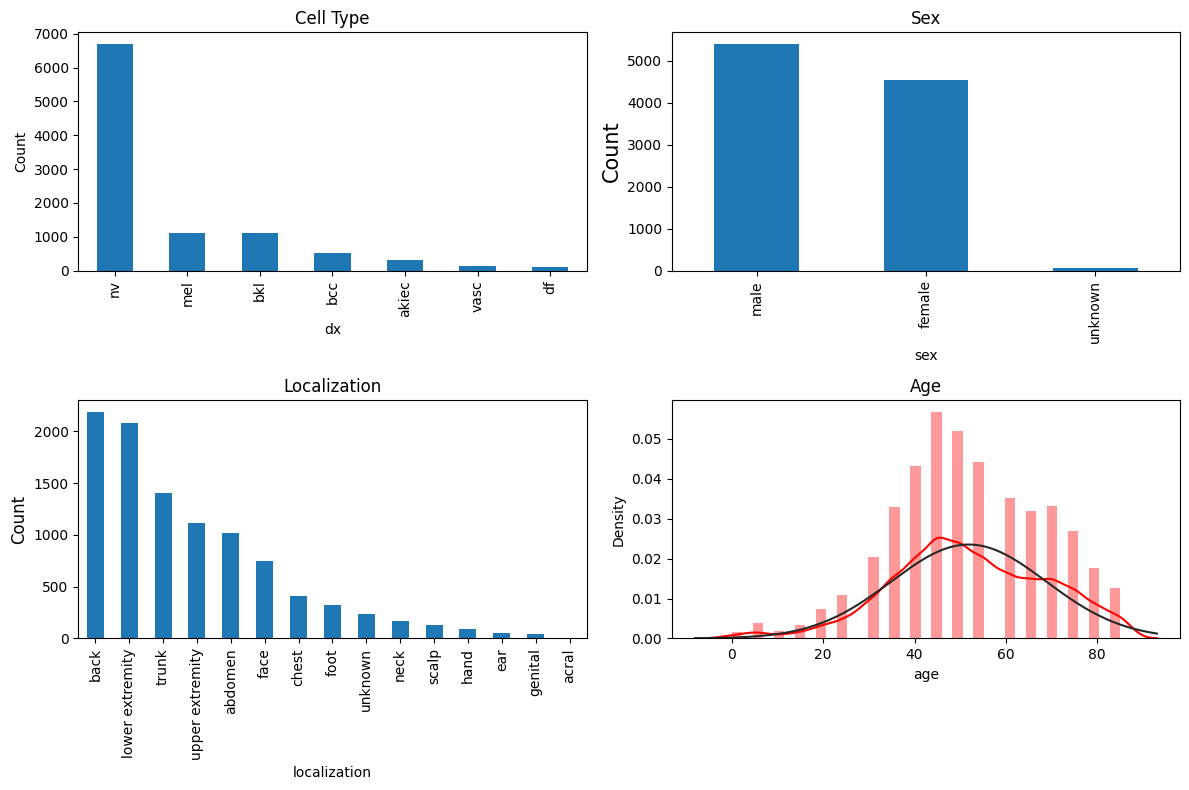

In [4]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

### Distribution of data into various classes 

In [5]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


### Balance data.

In [6]:

# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

print(df_0.shape)

(327, 8)


In [7]:
n_samples=6500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
print(df_0_balanced.shape)


(6500, 8)


In [8]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

### Classes should be balanced now.

In [9]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    6500
1    6500
2    6500
3    6500
4    6500
5    6500
6    6500
Name: count, dtype: int64


## Read images based on image ID from the CSV file

In [10]:
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-lesions-inzip', '*', '*.jpg'))}

### Define the path and add as a new column

In [11]:
#Define the path and add as a new column

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [12]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[150, 112, 104], [160, 125, 116], [162, 127,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[139, 80, 89], [131, 68, 71], [131, 66, 67],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[92, 60, 61], [128, 91, 93], [158, 121, 120]..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[197, 141, 171], [204, 148, 174], [201, 142,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[200, 176, 199], [206, 178, 201], [202, 171,..."


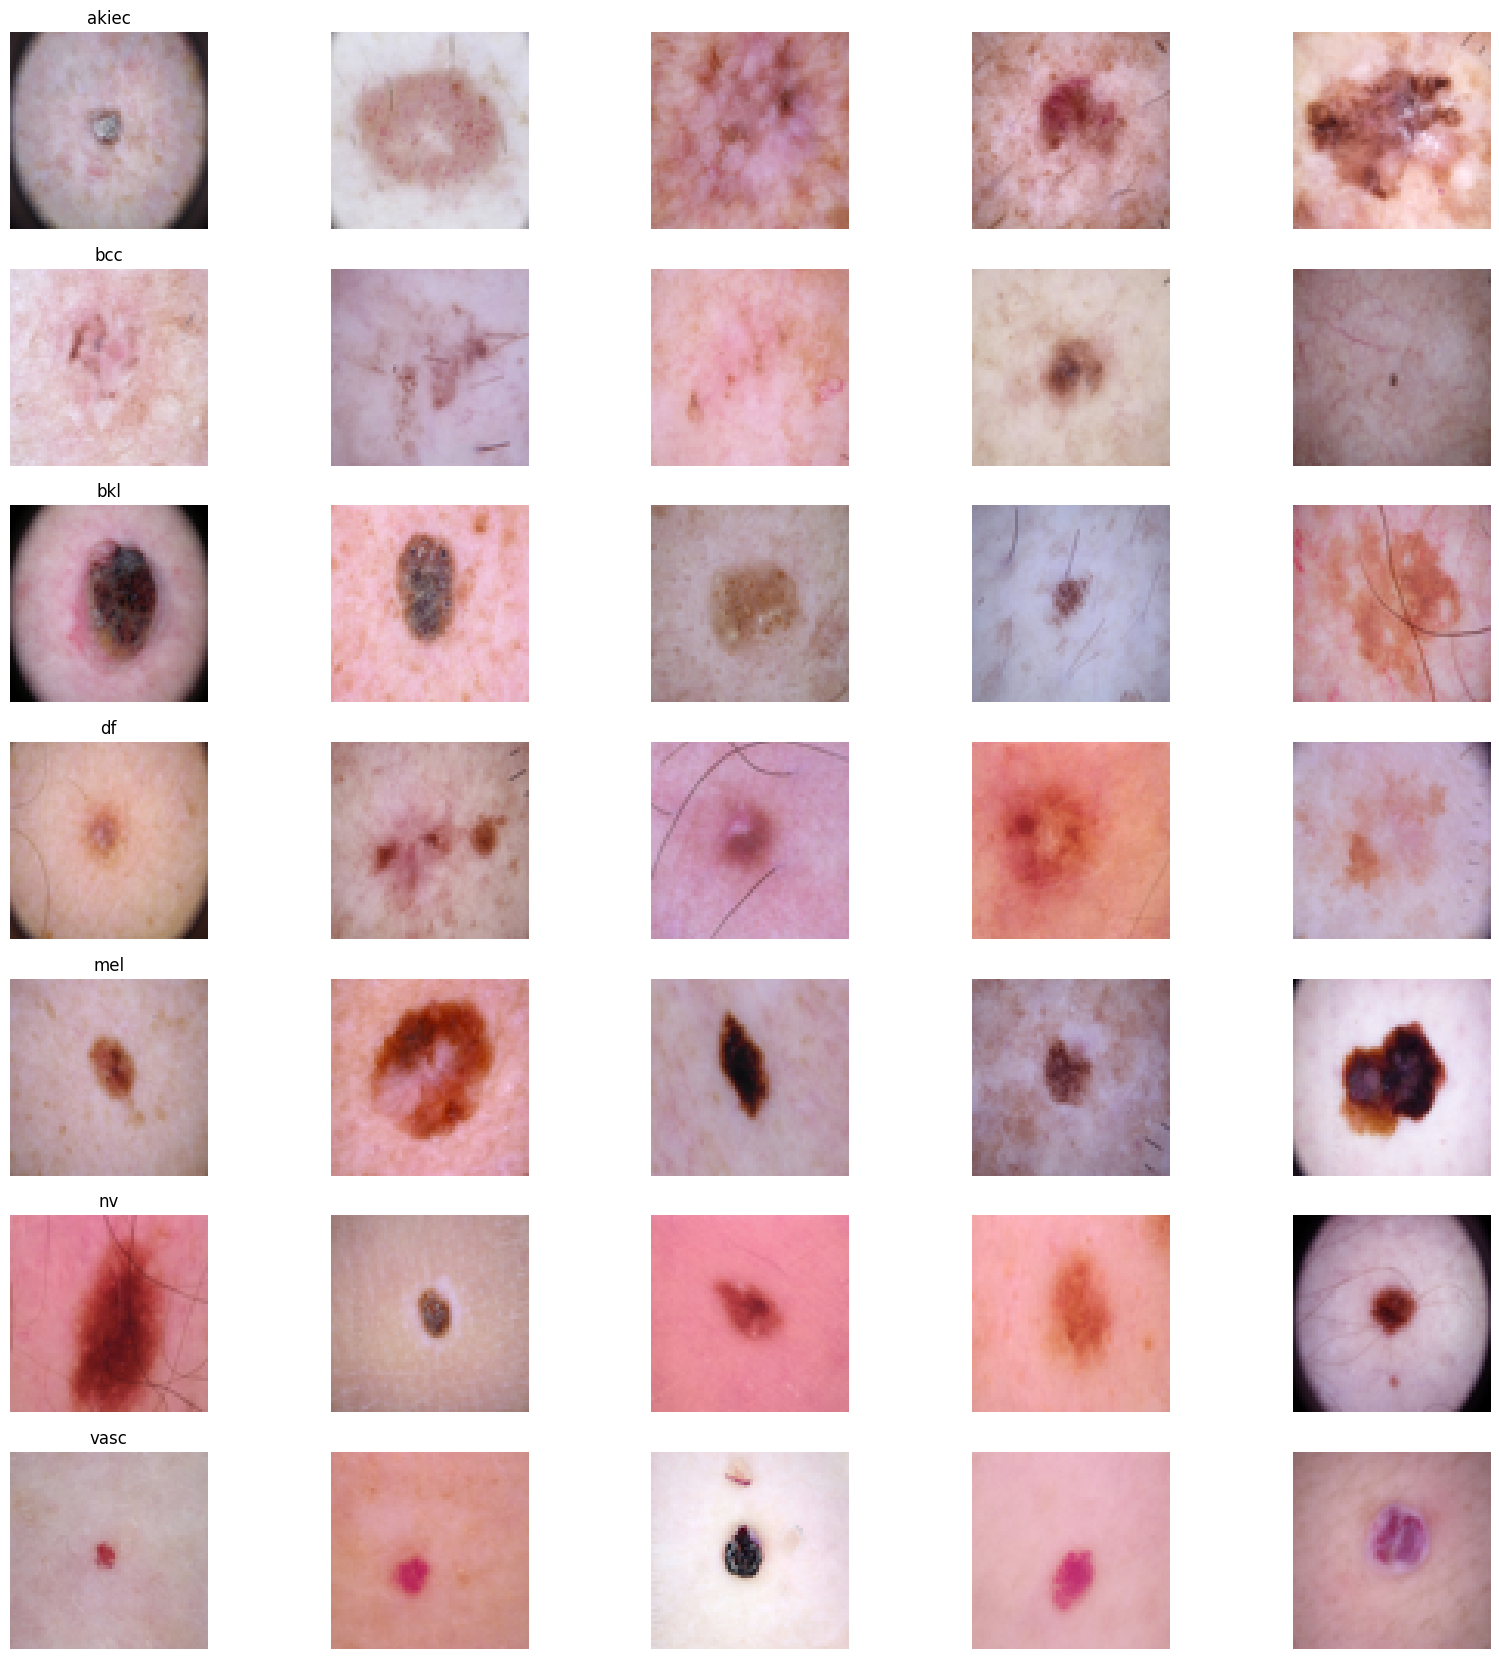

In [13]:
import matplotlib.pyplot as plt

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.show()


### Convert dataframe column of images into numpy array

In [14]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [15]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [16]:
num_classes = 7

In [17]:
#-------------------------------model------------------------------
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Normalization
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [18]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define input layer
input_layer = Input(shape=(64, 64, 3))

# Cast to float32
cast_to_float32 = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)

# Normalization layer
normalization = Normalization()(cast_to_float32)

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(normalization)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)

# Max pooling layer
pooling = MaxPooling2D(pool_size=(2, 2))(conv2)

# Dropout layer
dropout = Dropout(0.25)(pooling)

# Flatten layer
flatten = Flatten()(dropout)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(7, activation='softmax')(dense1)  # Assuming 7 classes

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=dense2)



# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,230 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 7 (32.00 B)

### Compile the model

In [19]:
# Compile the model with Adam optimizer and learning rate
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size = 32,
    validation_data=(x_test, y_test))

Epoch 1/15
  19/1067 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1411 - loss: 3.7544

I0000 00:00:1712902940.422493      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712902940.440309      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4370 - loss: 1.5064

W0000 00:00:1712902955.382544      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.4371 - loss: 1.5060 - val_accuracy: 0.8083 - val_loss: 0.5507
Epoch 2/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8520 - loss: 0.4228 - val_accuracy: 0.9262 - val_loss: 0.2243
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9409 - loss: 0.1721 - val_accuracy: 0.9492 - val_loss: 0.1529
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9678 - loss: 0.0891 - val_accuracy: 0.9739 - val_loss: 0.0860
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9799 - loss: 0.0624 - val_accuracy: 0.9791 - val_loss: 0.0883
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9839 - loss: 0.0502 - val_accuracy: 0.9692 - val_loss: 0.1201
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9859 - loss: 0.0455 - val_accuracy: 0.9860 - val_loss: 0.0725
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9859 - loss: 0.04

### Download Model

In [20]:
# Save the model
model.save("model.h5")

In [21]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 68/356 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1712903104.009752      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


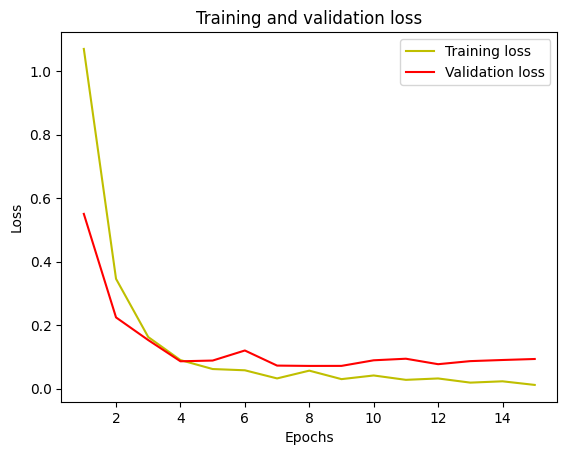

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

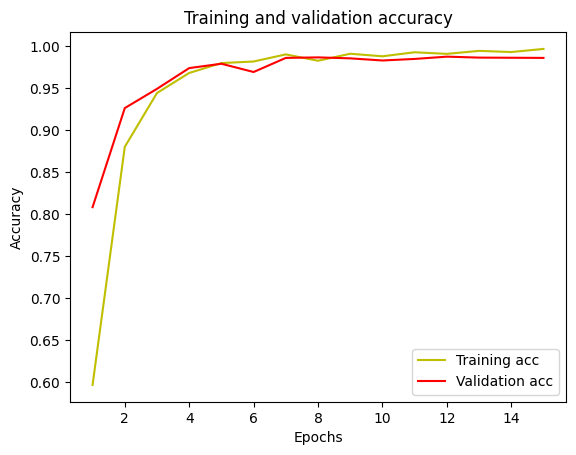

In [23]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Confusion Matrix

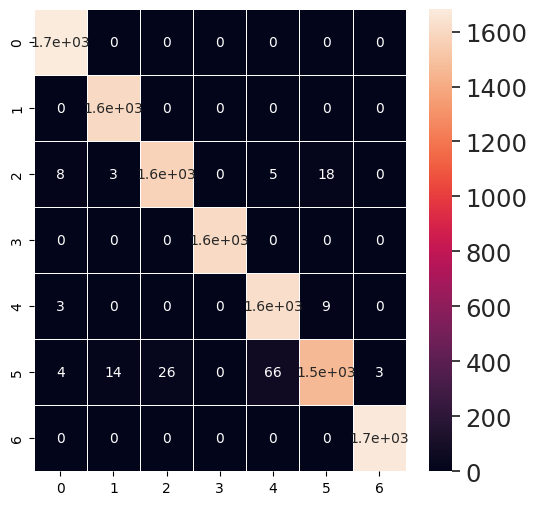

In [25]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, annot_kws={"size": 10})

plt.show()

### Classification Report

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1681
           1       0.99      1.00      0.99      1596
           2       0.98      0.98      0.98      1607
           3       1.00      1.00      1.00      1608
           4       0.96      0.99      0.98      1637
           5       0.98      0.93      0.95      1573
           6       1.00      1.00      1.00      1673

    accuracy                           0.99     11375
   macro avg       0.99      0.99      0.99     11375
weighted avg       0.99      0.99      0.99     11375



(array([0.  , 0.02, 0.04, 0.06, 0.08]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.08, '0.08')])

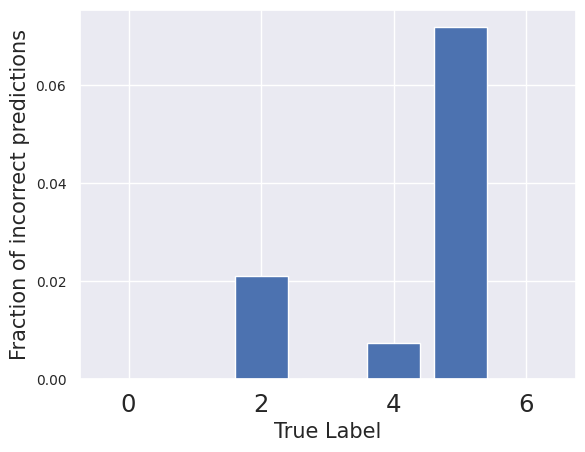

In [27]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label',fontsize=15)
plt.ylabel('Fraction of incorrect predictions',fontsize=15)
# Decrease label size
plt.yticks(fontsize=10)


## -------------------------------VGG16 model------------------------------


In [28]:
#-------------------------------VGG16 model------------------------------
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [29]:
# Define input layer
input_layer = Input(shape=(64, 64, 3))

# Load pre-trained VGG16 model
pre_trained_model = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [30]:
# Freeze layers in pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get the output of the pre-trained VGG16 model
output_vgg16 = pre_trained_model(input_layer)

In [31]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_vgg16)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,863 (57.14 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

Epoch 1/15
  13/1067 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.1735 - loss: 2.1982

W0000 00:00:1712903120.981420      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4192 - loss: 1.5085

W0000 00:00:1712903139.522781      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712903141.886651      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.4193 - loss: 1.5083 - val_accuracy: 0.6510 - val_loss: 0.9672
Epoch 2/15
   9/1067 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5349 - loss: 1.1591

W0000 00:00:1712903149.502677      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6016 - loss: 1.0520 - val_accuracy: 0.7149 - val_loss: 0.7921
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6590 - loss: 0.9082 - val_accuracy: 0.7556 - val_loss: 0.6890
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6914 - loss: 0.8127 - val_accuracy: 0.7775 - val_loss: 0.6245
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7196 - loss: 0.7438 - val_accuracy: 0.7895 - val_loss: 0.5692
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7372 - loss: 0.6894 - val_accuracy: 0.8088 - val_loss: 0.5285
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7550 - loss: 0.6351 - val_accuracy: 0.8236 - val_loss: 0.5091
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7564 - loss: 0.6304 - val_accuracy: 0.8330 - val_loss: 0.4540
Epoch 9/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7762 - loss: 0.58

### VGG model save

In [35]:
import os

# Save the model with the same name
model.save("Vgg16model_new.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [36]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

 11/356 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step 

W0000 00:00:1712903597.409529      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


W0000 00:00:1712903602.247164      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [37]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [38]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1681
           1       0.84      0.97      0.90      1596
           2       0.72      0.80      0.76      1607
           3       0.99      0.99      0.99      1608
           4       0.80      0.78      0.79      1637
           5       0.89      0.71      0.79      1573
           6       1.00      1.00      1.00      1673

    accuracy                           0.88     11375
   macro avg       0.88      0.88      0.88     11375
weighted avg       0.88      0.88      0.88     11375



## -------------------------------MobileNet model------------------------------


In [39]:
#-------------------------------MobileNet model------------------------------
from tensorflow.keras.applications import MobileNet

In [40]:
# Define input layer
input_layer = Input(shape=(64, 64, 3))

# Load pre-trained MobileNet model
pre_trained_model = MobileNet(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze layers except the last convolutional block
for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

# Get the output of the pre-trained MobileNet model
output_mobilenet = pre_trained_model(input_layer)

/tmp/ipykernel_34/2174945058.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNet(input_shape=(64, 64, 3), include_top=False, weights='imagenet')


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_mobilenet)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes


In [42]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 2, 2, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,754,183 (14.32 MB)

 Trainable params: 1,575,943 (6.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

### MobileNET model save

In [43]:
# Save the model
model.save("Mobilenet_model.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [44]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 52/356 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1712903638.712512      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


W0000 00:00:1712903642.356650      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [45]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.18      0.07      0.10      1681
           1       0.15      0.43      0.22      1596
           2       0.15      0.14      0.14      1607
           3       0.16      0.21      0.18      1608
           4       0.13      0.05      0.07      1637
           5       0.15      0.09      0.11      1573
           6       0.14      0.07      0.09      1673

    accuracy                           0.15     11375
   macro avg       0.15      0.15      0.13     11375
weighted avg       0.15      0.15      0.13     11375



## -------------------------------DenseNet121 model------------------------------


In [47]:
#-------------------------------DenseNet121 model------------------------------
from tensorflow.keras.applications import DenseNet121

In [48]:
# Define input layer
input_layer = Input(shape=(64, 64, 3))

# Load pre-trained DenseNet121 model
pre_trained_model = DenseNet121(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

# Freeze layers except the last convolutional block
for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

# Get the output of the pre-trained DenseNet121 model
output_densenet = pre_trained_model(input_layer)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_densenet)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [50]:
# Print model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,562,823 (28.85 MB)

 Trainable params: 564,231 (2.15 MB)

 Non-trainable params: 6,998,592 (26.70 MB)

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

Epoch 1/15
   9/1067 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.1546 - loss: 3.9850

W0000 00:00:1712903681.095355      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4603 - loss: 1.4816

W0000 00:00:1712903709.276633      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712903720.321006      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.4603 - loss: 1.4813 - val_accuracy: 0.7500 - val_loss: 0.6552
Epoch 2/15
   7/1067 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.6584 - loss: 0.8246

W0000 00:00:1712903734.757415      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.6654 - loss: 0.8422 - val_accuracy: 0.8247 - val_loss: 0.4731
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7308 - loss: 0.6808 - val_accuracy: 0.8563 - val_loss: 0.3754
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.7754 - loss: 0.5708 - val_accuracy: 0.8863 - val_loss: 0.3181
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8030 - loss: 0.4898 - val_accuracy: 0.8956 - val_loss: 0.2909
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8265 - loss: 0.4442 - val_accuracy: 0.9159 - val_loss: 0.2335
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8366 - loss: 0.4139 - val_accuracy: 0.9210 - val_loss: 0.2184
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8537 - loss: 0.3675 - val_accuracy: 0.9332 - val_loss: 0.1963
Epoch 9/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8652 - loss: 0.34

### Densenet Model Save

In [52]:
# Save the model
model.save("Densenet_model.h5")

ValueError: Unable to synchronously create dataset (name already exists)

In [53]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 10/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

W0000 00:00:1712904050.061912      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step


W0000 00:00:1712904062.608495      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [54]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [55]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1681
           1       0.98      1.00      0.99      1596
           2       0.93      0.93      0.93      1607
           3       1.00      1.00      1.00      1608
           4       0.92      0.84      0.88      1637
           5       0.85      0.88      0.87      1573
           6       1.00      1.00      1.00      1673

    accuracy                           0.95     11375
   macro avg       0.95      0.95      0.95     11375
weighted avg       0.95      0.95      0.95     11375



## -------------------------------ResNet50 model------------------------------


In [56]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0
